In [1]:
# Importing libraires and defining model for fitting
import os
import ccd_helpers
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from skimage import morphology as morph
import lmfit
import math
from lmfit.models import GaussianModel
from lmfit.lineshapes import gaussian
from scipy.interpolate import interp1d

from PIL import Image, ImageOps


## Check the raw image data

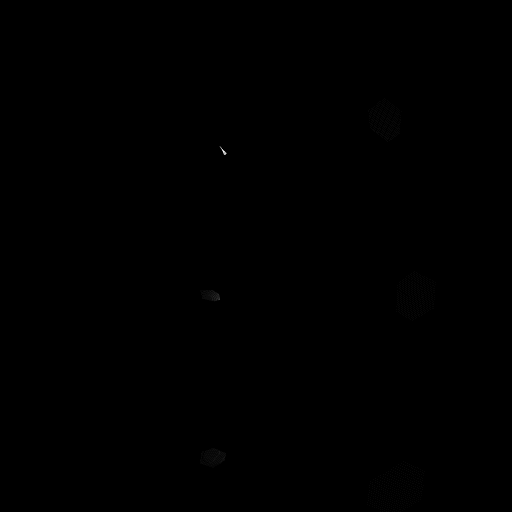

In [2]:
# Import tiff files
img_data = Image.open('ScanXYZ_tiff/002.tiff')

img_data

## Convert the image data to floats and plot to ensure it was done correctly

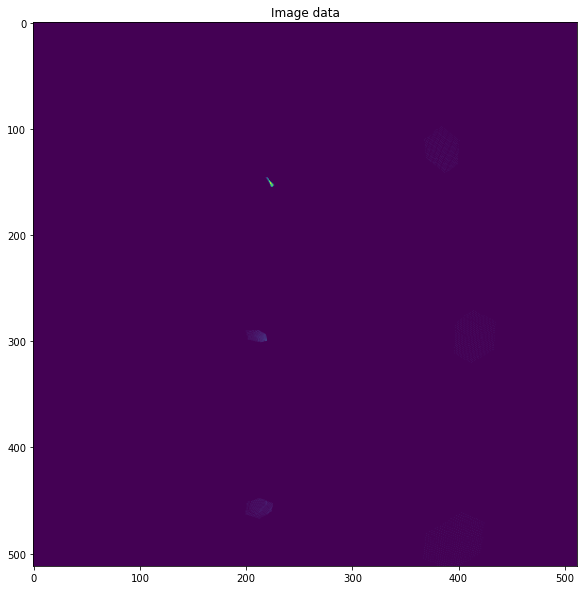

In [3]:
z_grid = np.array(img_data).astype('float')

# Plotting for reference
fig = plt.figure(figsize=(16, 10))
# setting values to rows and column variables
rows = 1 
columns = 1

fig.add_subplot(rows, columns, 1) 
# showing image
plt.title("Image data")
plt.imshow(z_grid)

## Check there are 6 subsections ( corrseponding to the  axis ) by checking the image data as a black and white image

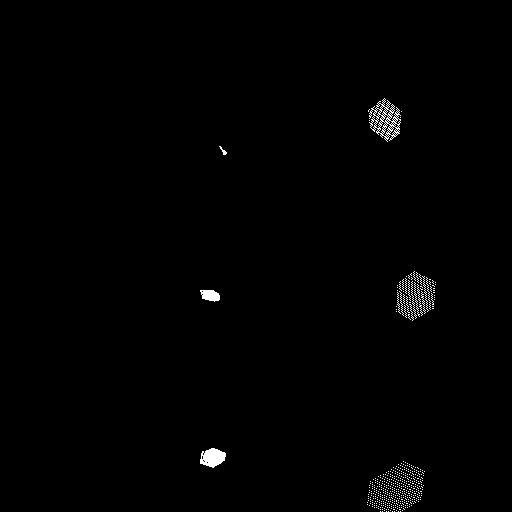

In [4]:
ImageOps.grayscale(img_data)

## Plot one of the images in 3 dimensions to help visualize which areas we are receving info; the largest spikes should correspond the z axis the particle is in, the x and y should be rooughly the same ( see callibration pdf for details )

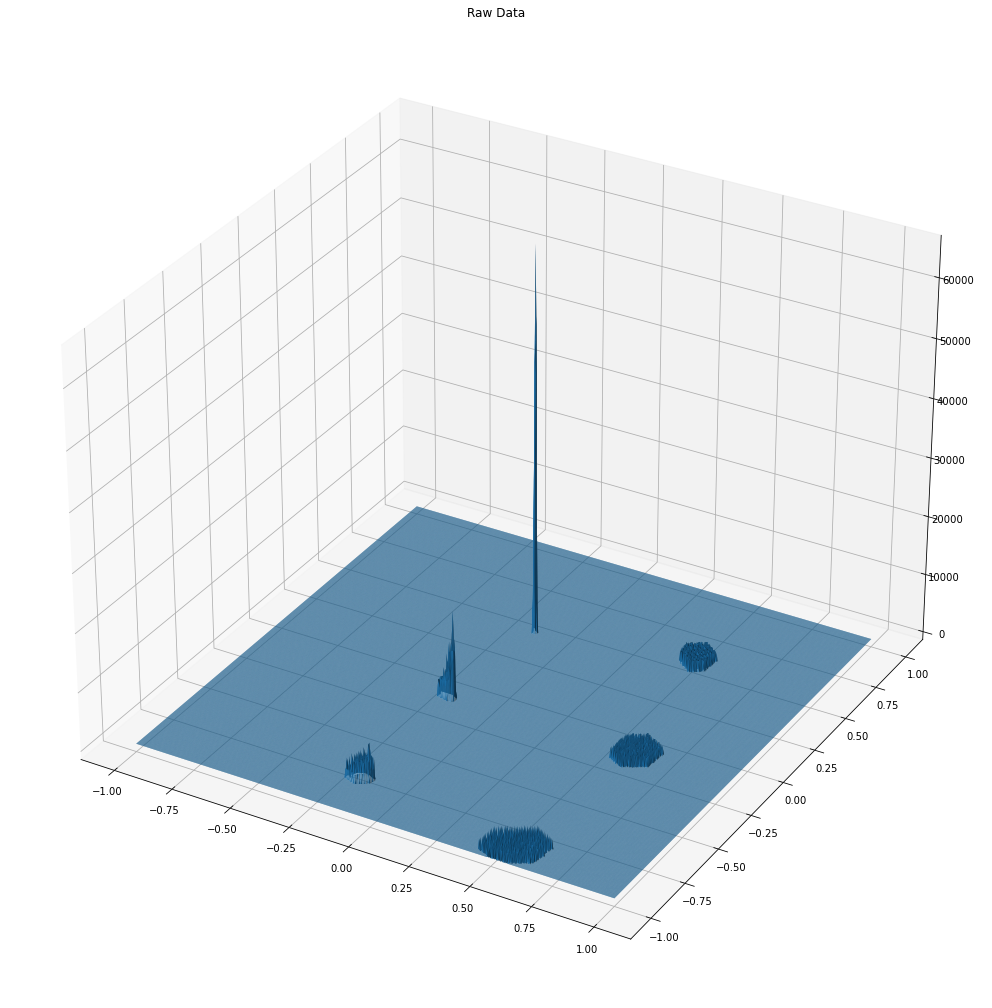

In [5]:
 # Get the dimensions of the image; used to create the x and y values
dimensions = z_grid.shape 

# With the length of the second dimension, create - 1 ~ 1 with dimensions[1] value 
x = np.linspace(-1, 1, dimensions[1])

# With the length of the first dimension, create - 1 ~ 1 with dimensions[0] value
y = np.linspace(1, -1, dimensions[0])

# Make a grid of the xand 1 data
x_grid, y_grid = np.meshgrid(x, y) # 257 x 257

# Raw Data
X = x_grid.flatten()
Y = y_grid.flatten()

Z = z_grid.flatten()
ccd_helpers.tri_plot(X, Y, Z, "Raw Data")

# Note on below
It should be noted the hard coded values are those that were defiend by the head researcher of this project to the specifications of the micro lens array , and as such hard coding is not only allowed, but for now, neccesary. In the future, the values may change as the development of the microsope continues.

# Function to get the trajectory of the particle

In [11]:
def get_particle_traj(folder_name, xtraj, ytraj, ztraj):
    """ Gets the x, y and z particle trajectories from csv files and appends them to the
        Lists provded. For now the folder_name assumes it starts in the directory of "Scan XYZ". 
        Will need to be adjusted in the folder_name function depening on the nature of files coming in.

    Args:
        folder_name[string]: The name of the folder to extract csv files from.
        xtraj[List / array]: An empty list to append the x traj values to.
        ytraj[List / array]: An empty list to append the y traj values to.
        ztraj[List / array]: An empty list to append the z traj values to.

    Returns:
        Does't return anything, but appends to the lists provided.

    """
    
    # Defining Depth and sections of photo   
    depth = [-5.5,-5.4,-5.3,-5.2,-5.1,-5.0]
    selection = [ [-0.546, 0, 0.2775, 0.8325],
                  [-0.546, 0, - 0.2775, 0.2775],
                  [-0.546, 0, -0.8325, - 0.2775],
                  [0, 0.546, 0.2775, 0.8325],
                  [0, 0.546, - 0.2775,  0.2775],
                  [0, 0.546, -0.8325, - 0.2775] ]

    # first get folder with all files to go through
    imgs = ccd_helpers.get_img_files(folder_name)

    # the length of that file will be the outer loop
    img_loop = len(imgs)

    # Loop through the length of the img files
    for i in range(img_loop):

        # select the image file name string
        img = imgs[i]
        #print(imgs[i])
        
        # build the file path using the folder name and img file name
        filepath = folder_name + "/" + img
        
        # Open the image file and convert it to a np array of floats
        img_data = Image.open(filepath)
        z_grid = np.array(img_data).astype('float')

        
        # Get the dimensions of the image; used to create the x and y values
        dimensions = z_grid.shape 

        # With the length of the second dimension, create - 1 ~ 1 with dimensions[1] value 
        x = np.linspace(-1, 1, dimensions[1])

        # With the length of the first dimension, create - 1 ~ 1 with dimensions[0] value
        y = np.linspace(1, -1, dimensions[0])
        
        # Make a grid of the xand 1 data
        x_grid, y_grid = np.meshgrid(x, y) # 257 x 257
        
        #apply threshold 
#         threshold = np.max(z_grid) * 0.02
#         z_grid[z_grid < threshold] = 0

        # For each of the 6 sections in each cv
        coefs = [] 
        coefs_a = []
        coefs_cx = []
        coefs_cy = []

        # iterate over windows
        for j in range(6):
            # Define window
            xmin = selection[j][0]
            xmax = selection[j][1]
            ymin = selection[j][2]
            ymax = selection[j][3]

            # Define offsets
            xctr = (xmin + xmax) / 2
            yctr = (ymin + ymax) / 2

            # Define subsections
            mask_x = np.logical_and(x_grid >= xmin, x_grid <= xmax)
            mask_y = np.logical_and(y_grid >= ymin, y_grid <= ymax)
            mask = np.logical_and(mask_x,mask_y)


            # Apply mask to subsections
            X = x_grid[mask] # makes 1D np array where mask returns True
            Y = y_grid[mask]
            Z = z_grid[mask]

            # Offset the XY data
            X -= xctr
            Y -= yctr

            # Get the labels
            mask = mask.astype(int)
            z_label = morph.label(mask, connectivity=2) # mask - ndarray of dtype int
            

            #print("Subsection " + str(i))
            #Function appends to coefs, 2D fit, append to ceofs inside function
            ccd_helpers.gaussian2D_fit(z_label, X, Y, Z, coefs, plot=False)

            #append a, cx and cy values to arrays
            coefs_a.append(coefs[j][0][0])
            coefs_cx.append(coefs[j][0][3])
            coefs_cy.append(coefs[j][0][4])


        # Gaussian fit 1D -> zparticle and append to array
        zparticle = ccd_helpers.gaussian1D_fit(depth, coefs_a)
        ztraj.append(zparticle)       

        # Interp for xparticle, yparticle
        x_int = np.interp(zparticle, depth, coefs_cx)
        y_int = np.interp(zparticle, depth, coefs_cy)

        # Save the points
        xtraj.append(x_int)
        ytraj.append(y_int)
            

# Processing all the data in the ScanXYZ_tiff folder

In [12]:
# Arrays to hold the x, y and z data
xtraj = []
ytraj = []
ztraj = []
get_particle_traj("ScanXYZ_tiff", xtraj, ytraj, ztraj)

# Plotting the trajectory of the particle

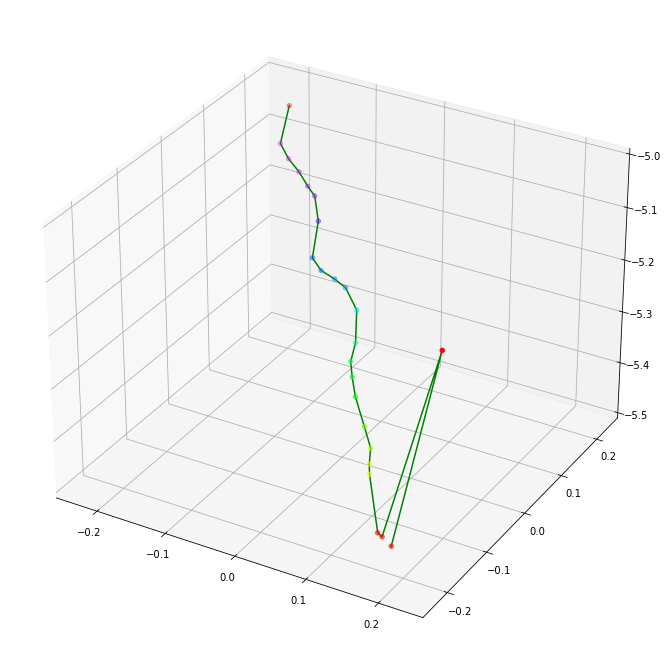

In [13]:

# Crete the figure and the axes
fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection="3d")

# Define the x, y and z lines and plot
z_line = ztraj
x_line = xtraj
y_line = ytraj
ax.plot3D(x_line, y_line, z_line, 'green')

# Define the points to plot
z_points = ztraj
x_points = xtraj
y_points = ytraj
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

# Changed to represent the new data for Calibration
ax.set_xlim3d([-0.25,0.25])
ax.set_ylim3d([-0.25,0.25])
ax.set_zlim3d([-5.5,-5.0])
# Show the plot
plt.show()

# Saving the trjactory data in a csv

In [14]:
import pandas as pd

# Save the arrays
a = np.array(xtraj)
b = np.array(ytraj)
c = np.array(ztraj)

# Convert to dataframe and save to a csv file
df = pd.DataFrame({"X trajectory" : a, "Y trajectory" : b, "Z trajectory" : c})

In [15]:
# The path data we followed
df

,X trajectory,Y trajectory,Z trajectory
0,0.159346,-0.156763,-5.500000
1,0.289135,-0.276701,-5.000000
2,0.139497,-0.144381,-5.500000
3,0.130611,-0.139355,-5.500000
4,0.106107,-0.117068,-5.413830
5,0.097370,-0.102345,-5.408535
6,0.090346,-0.086663,-5.392079
7,0.075799,-0.076827,-5.363801
8,0.054650,-0.062166,-5.325632
9,0.038001,-0.041169,-5.309088
